# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Dataset

In [2]:
df = pd.read_csv("train.csv")


print("Dataset Shape", df.shape)
print(df['target'].value_counts())


Dataset Shape (7613, 5)
target
0    4342
1    3271
Name: count, dtype: int64


# Train Test Split

In [3]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=0
)

print("Train Shape", X_train.shape)
print("Test Shape", X_test.shape)

print("Train Target Shape", y_train.shape)
print("Test Target Shape", y_test.shape)

Train Shape (6851, 4)
Test Shape (762, 4)
Train Target Shape (6851,)
Test Target Shape (762,)


# Bar Plot in Targets

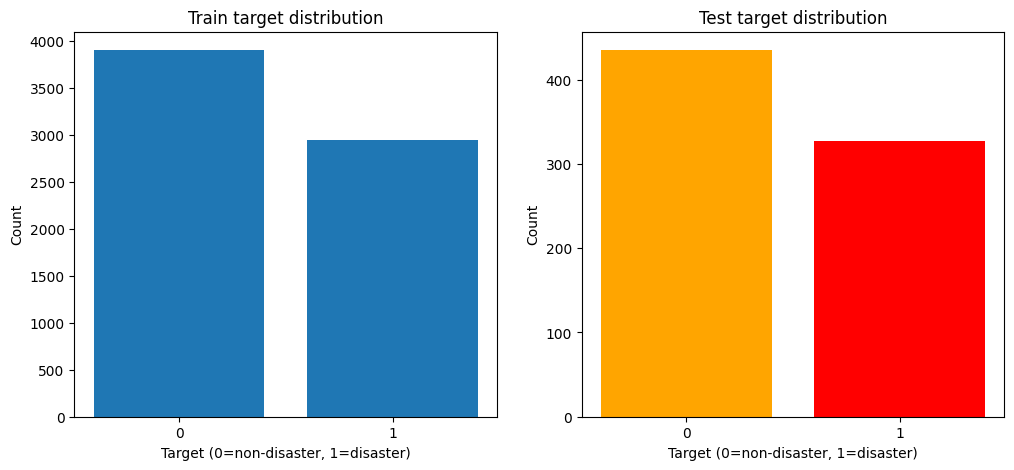

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

train_counts = y_train.value_counts().sort_index()
axes[0].bar(train_counts.index.astype(str), train_counts.values)
axes[0].set_title('Train target distribution')
axes[0].set_xlabel('Target (0=non-disaster, 1=disaster)')
axes[0].set_ylabel('Count')

test_counts = y_test.value_counts().sort_index()
axes[1].bar(test_counts.index.astype(str), test_counts.values, color=['orange','red'])
axes[1].set_title('Test target distribution')
axes[1].set_xlabel('Target (0=non-disaster, 1=disaster)')
axes[1].set_ylabel('Count')

plt.show()

Όχι, το dataset δεν είναι ισορροπημένο, αλλά παρουσιάζει έναν μέτριο βαθμό ανισορροπίας (έχει δηλαδή επαρκή εκπροσώπηση και η κλάση 1).

# Preprocess

In [5]:
X_train = X_train.drop(columns=['id', 'location'])
X_test = X_test.drop(columns=['id', 'location'])

X_train = X_train.fillna("null")
X_test = X_test.fillna("null")


X_train['inputs'] = X_train['keyword'] + ' ' + X_train['text']
X_test['inputs'] = X_test['keyword'] + ' ' + X_test['text']

X_train = X_train.drop(columns=['keyword', 'text'])
X_test = X_test.drop(columns=['keyword', 'text'])


print(X_train.head())
print(X_test.head())

                                                 inputs
6669  threat Meek Mill responds to DrakeÛªs OVO Fes...
3940  flood survived the plague\nfloated the flood\n...
7217  weapons #Kick Hendrixonfire  @'=BLACKCATS= | B...
2234  deluge Vince McMahon once again a billionaire:...
4233  hazardous Is it possible to sneak into a hospi...
                                                 inputs
604   bioterror #FedEx no longer to transport bioter...
5374  panic Panic over: Patient in Alabama tests neg...
3022  dust%20storm New Mad Max Screenshots Show Off ...
3357  evacuated Rocky fire in Northern California sw...
4726  lava @YoungHeroesID Lava Blast &amp; Power Red...


# Cleaning Functions

In [6]:

import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text


contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def clean_text(text):
    """Use all the above functions to clean the text"""
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = replaceContraction(text)
    return text

<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2913757981.py:18: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-2913757981.py:24: Sy

1. removeUnicode

Γιατί: Αφαιρεί unicode χαρακτήρες και emojis που δεν προσφέρουν σημασιολογική πληροφορία στο disaster classification.

⸻

2. replaceURL

Γιατί: Τα URLs δεν σχετίζονται με το αν περιγράφεται φυσική καταστροφή, αλλά το placeholder “url” διατηρεί την πληροφορία ύπαρξης link.

⸻

3. replaceAtUser

Γιατί: Τα @mentions δεν συμβάλλουν στο περιεχόμενο του γεγονότος και ενοποιούνται σε κοινό token.

⸻

4. removeHashtagInFrontOfWord

Γιατί: Τα hashtags συχνά περιέχουν λέξεις-κλειδιά (π.χ. #fire, #flood) που είναι χρήσιμες, οπότε κρατάμε τη λέξη χωρίς το #.

⸻

5. replaceMultiExclamationMark

Γιατί: Η ένταση (!!!) είναι σημαντική σε tweets έκτακτης ανάγκης και κωδικοποιείται σε σταθερό token αντί να χαθεί.

⸻

6. replaceMultiQuestionMark

Γιατί: Οι πολλαπλές ερωτήσεις εκφράζουν αβεβαιότητα ή πανικό και αποτυπώνονται με ενιαίο σύμβολο.

⸻

7. replaceMultiStopMark

Γιατί: Τα πολλαπλά dots (“…”) δηλώνουν συναισθηματική φόρτιση και αποτυπώνονται με ενιαίο σύμβολο.

----

8. replaceContraction

Γιατί: Ενοποιεί διαφορετικές μορφές της ίδιας λέξης (π.χ. can’t → cannot), βελτιώνοντας τη γλωσσική συνέπεια.

In [7]:
X_train['inputs_clean'] = X_train['inputs'].apply(clean_text)
X_test['inputs_clean'] = X_test['inputs'].apply(clean_text)

# Έλεγχος
X_train[['inputs', 'inputs_clean']].head()

,inputs,inputs_clean
6669,threat Meek Mill responds to DrakeÛªs OVO Fes...,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood survived the plague\nfloated the flood\n...,flood survived the plague\nfloated the flood\n...
7217,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...,weapons Kick Hendrixonfire atUser | BIG NOOB ...
2234,deluge Vince McMahon once again a billionaire:...,deluge Vince McMahon once again a billionaire:...
4233,hazardous Is it possible to sneak into a hospi...,hazardous Is it possible to sneak into a hospi...


# Numpy Arrays

In [8]:
X_train_inputs = X_train['inputs_clean'].values
y_train_targets = y_train.values

X_test_inputs = X_test['inputs_clean'].values
y_test_targets = y_test.values

print(type(X_train_inputs), X_train_inputs.shape)
print(type(y_train_targets), y_train_targets.shape)

print(X_train_inputs[:5])
print(y_train_targets[:5])

<class 'numpy.ndarray'> (6851,)
<class 'numpy.ndarray'> (6851,)
['threat Meek Mill responds to Drakes OVO Fest set with wedgie threat url'
 'flood survived the plague\nfloated the flood\njust peeked our heads above the mud\nno one is immune\ndeafening bells\nmy god will we survive ourselves?'
 "weapons Kick Hendrixonfire  atUser | BIG NOOB CONQUEST | MIXED MAPS | ALL WEAPONS' for violated K/DR  Limit /Server  max 3"
 'deluge Vince McMahon once again a billionaire: I remember reading a deluge of posts about Vince McMahon losing $350 m multiStop  url'
 'hazardous Is it possible to sneak into a hospital so I can stab myself with a hazardous needle and inject some crazy disease into my veins until I die']
[1 0 0 0 0]


#TF-IDF

In [9]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_inputs)
X_test_tfidf = tfidf_vectorizer.transform(X_test_inputs)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (6851, 13916)
Test TF-IDF shape: (762, 13916)


# Linear SVM

In [10]:
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(X_train_tfidf, y_train_targets)

y_train_pred = svm_clf.predict(X_train_tfidf)
y_test_pred = svm_clf.predict(X_test_tfidf)


def print_metrics(y_true, y_pred, dataset_name):
    print(f"{dataset_name} metrics:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("-" * 30)

# Metrics
print_metrics(y_train_targets, y_train_pred, "Train")
print_metrics(y_test_targets, y_test_pred, "Test")

Train metrics:
Accuracy : 0.9635089767917092
Precision: 0.9759717314487633
Recall   : 0.9381793478260869
F1-score : 0.9567024593003117
------------------------------
Test metrics:
Accuracy : 0.7952755905511811
Precision: 0.7766990291262136
Recall   : 0.7339449541284404
F1-score : 0.7547169811320755
------------------------------


Recall ειναι η πιο σημαντική μετρική για το συγκεκριμένο πρόβλημα, γιατί σε σύστημα έγκαιρης προειδοποίησης φυσικών καταστροφών το false negative (να μην ανιχνευτεί πραγματική καταστροφή) έχει υψηλό κόστος, ενώ ένα false positive είναι λιγότερο επικίνδυνο.

Το F1-score μπορεί να χρησιμοποιηθεί ως συνολική σύνοψη της απόδοσης, αλλά η προτεραιότητα είναι η έγκαιρη ανίχνευση όλων των πραγματικών περιστατικών.

#PCA

In [11]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_dense)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print("Αριθμός συνιστωσών για 95% πληροφορίας:", n_components_95)

pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

Αριθμός συνιστωσών για 95% πληροφορίας: 3905


# Linear SVC vs SVC with RBF Kernel

In [12]:
def evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("-" * 30)

linear_svc = LinearSVC(random_state=0)
evaluate(
    linear_svc,
    X_train_pca,
    X_test_pca,
    y_train_targets,
    y_test_targets,
    "LinearSVC + PCA"
)

rbf_svc = SVC(kernel='rbf', random_state=0)
evaluate(
    rbf_svc,
    X_train_pca,
    X_test_pca,
    y_train_targets,
    y_test_targets,
    "SVC (RBF) + PCA"
)

LinearSVC + PCA
Accuracy : 0.8044619422572179
Precision: 0.7870967741935484
Recall   : 0.746177370030581
F1-score : 0.7660910518053375
------------------------------
SVC (RBF) + PCA
Accuracy : 0.8254593175853019
Precision: 0.8277027027027027
Recall   : 0.7492354740061162
F1-score : 0.7865168539325843
------------------------------


1. Default Τιμή: γ=’scale’

Όταν η παράμετρος γ ορίζεται ως 'scale' (η προεπιλεγμένη/default τιμή), η τιμή του γ υπολογίζεται ως:

γ=
n_features⋅X.var()
1
​

n_features (Αριθμός Χαρακτηριστικών): Είναι ο αριθμός των χαρακτηριστικών (στηλών) στο σύνολο δεδομένων εκπαίδευσης X.

X.var() (Διακύμανση): Είναι η διακύμανση (variance) όλων των δεδομένων του X.

Ερμηνεία: Η τιμή γ προσαρμόζεται ανάλογα με τον αριθμό των χαρακτηριστικών και τη συνολική διασπορά (διακύμανση) των δεδομένων.

2. Τιμή: γ=’auto’

Όταν η παράμετρος γ ορίζεται ως 'auto', η τιμή του γ υπολογίζεται ως:

γ=
n_features
1
​

n_features (Αριθμός Χαρακτηριστικών): Είναι ο αριθμός των χαρακτηριστικών (στηλών) στο σύνολο δεδομένων εκπαίδευσης X.

Ερμηνεία: Η τιμή γ εξαρτάται μόνο από τον αριθμό των χαρακτηριστικών. Αυτό είναι ισοδύναμο με το να αγνοήσουμε τη διακύμανση του X και να θεωρήσουμε X.var()=1 στον τύπο του 'scale'.

# Retrain with γ = auto

In [13]:
rbf_svc_auto = SVC(kernel='rbf', gamma='auto', random_state=0)
rbf_svc_auto.fit(X_train_pca, y_train_targets)

y_train_rbf_auto = rbf_svc_auto.predict(X_train_pca)
y_test_rbf_auto = rbf_svc_auto.predict(X_test_pca)

# Combined Results

In [14]:
models = {
    "LinearSVC (no PCA)": svm_clf,
    "LinearSVC + PCA": linear_svc,
    "SVC (RBF, scale)": rbf_svc,
    "SVC (RBF, auto)": rbf_svc_auto
}

metrics_dict = {}

for name, model in models.items():
    if name == "LinearSVC (no PCA)":
        y_pred_train = svm_clf.predict(X_train_tfidf)
        y_pred_test = svm_clf.predict(X_test_tfidf)
    elif name == "LinearSVC + PCA":
        y_pred_train = linear_svc.predict(X_train_pca)
        y_pred_test = linear_svc.predict(X_test_pca)
    elif name == "SVC (RBF, scale)":
        y_pred_train = rbf_svc.predict(X_train_pca)
        y_pred_test = rbf_svc.predict(X_test_pca)
    else:
        y_pred_train = rbf_svc_auto.predict(X_train_pca)
        y_pred_test = rbf_svc_auto.predict(X_test_pca)

    metrics_dict[name] = {
        "Train Accuracy": accuracy_score(y_train_targets, y_pred_train),
        "Test Accuracy": accuracy_score(y_test_targets, y_pred_test),
        "Train Precision": precision_score(y_train_targets, y_pred_train),
        "Test Precision": precision_score(y_test_targets, y_pred_test),
        "Train Recall": recall_score(y_train_targets, y_pred_train),
        "Test Recall": recall_score(y_test_targets, y_pred_test),
        "Train F1": f1_score(y_train_targets, y_pred_train),
        "Test F1": f1_score(y_test_targets, y_pred_test)
    }

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
LinearSVC (no PCA),0.963509,0.795276,0.975972,0.776699,0.938179,0.733945,0.956702,0.754717
LinearSVC + PCA,0.937235,0.804462,0.952484,0.787097,0.898777,0.746177,0.924851,0.766091
"SVC (RBF, scale)",0.943658,0.825459,0.970567,0.827703,0.896060,0.749235,0.931826,0.786517
"SVC (RBF, auto)",0.570282,0.570866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Bar Plot for Results

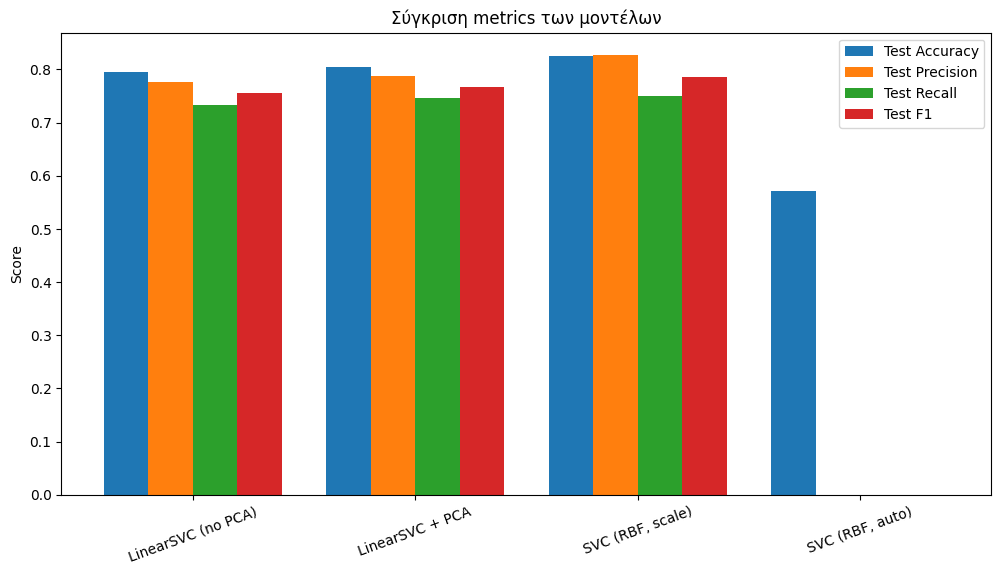

In [17]:
metrics_to_plot = ["Test Accuracy", "Test Precision", "Test Recall", "Test F1"]

x = np.arange(len(metrics_df))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, metrics_df[metric], width, label=metric)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(metrics_df.index, rotation=20)
ax.set_ylabel("Score")
ax.set_title("Σύγκριση metrics των μοντέλων")
ax.legend()
plt.show()

# Gaussian Naive Bayes

In [18]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense, y_train_targets)

y_train_pred = gnb.predict(X_train_dense)
y_test_pred = gnb.predict(X_test_dense)

print("Gaussian Naive Bayes metrics:")
print("Train Accuracy :", accuracy_score(y_train_targets, y_train_pred))
print("Test Accuracy  :", accuracy_score(y_test_targets, y_test_pred))
print("Train Precision:", precision_score(y_train_targets, y_train_pred))
print("Test Precision :", precision_score(y_test_targets, y_test_pred))
print("Train Recall   :", recall_score(y_train_targets, y_train_pred))
print("Test Recall    :", recall_score(y_test_targets, y_test_pred))
print("Train F1      :", f1_score(y_train_targets, y_train_pred))
print("Test F1       :", f1_score(y_test_targets, y_test_pred))

Gaussian Naive Bayes metrics:
Train Accuracy : 0.8822069770836374
Test Accuracy  : 0.6167979002624672
Train Precision: 0.7848573713676353
Test Precision : 0.5360824742268041
Train Recall   : 1.0
Test Recall    : 0.7951070336391437
Train F1      : 0.879462285287528
Test F1       : 0.6403940886699507


Recall παραμένει η πιο σημαντική μετρική για το συγκεκριμένο πρόβλημα, γιατί σε σύστημα έγκαιρης προειδοποίησης φυσικών καταστροφών το false negative (να μην ανιχνευτεί πραγματική καταστροφή) έχει υψηλό κόστος, ενώ ένα false positive είναι λιγότερο επικίνδυνο.

Το F1-score μπορεί να χρησιμοποιηθεί ως συνολική σύνοψη της απόδοσης, αλλά η προτεραιότητα είναι η έγκαιρη ανίχνευση όλων των πραγματικών περιστατικών.